# **Parker Christenson Assignment 2.1: Text Classification using Word Embeddings**


## Instructions 
`Prior to beginning work on this assignment, review the week's lab session.`

#### Dataset

The dataset comprises newsgroup documents categorized into 20 different topics. Each document is labeled with its corresponding newsgroup category.

Download the dataset from the following link: https://www.kaggle.com/datasets/crawford/20-newsgroups?resource=download


-   Load the "20 Newsgroups" dataset into a pandas DataFrame.
-   Preprocess the text data: remove stopwords, punctuation, convert to lowercase, etc.
-   Split the data into training and testing sets.
-   Utilize pre-trained word embeddings (e.g., Word2Vec, GloVe) and/or train your own embeddings using the training data.
-   Build a text classification model using a classifier of your choice (e.g., Logistic Regression, Support Vector Machine, Neural Network).
-   Train the model using the transformed training data (with embeddings).
-   Predict the categories for the testing data.
-   Evaluate the model's performance
-   Evaluate the model's performance using the following classification metrics:
    -   Accuracy
    -   Precision (weighted)
    -   Recall (weighted)
    -   F1 Score (weighted)
    -   Confusion Matrix
    -   Area Under the Receiver Operating Characteristic curve (AUC-ROC)

In [100]:
# text pre processing imports 
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
from nltk import pos_tag
from tqdm import tqdm
import os


# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# tensorflow imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

In [49]:
print("Tensorflow version: ", tf.__version__)
print("The GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow version:  2.17.0
The GPU is available
Num GPUs Available:  1


In [50]:
# Loading the data set from sklearn
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')

print("There are total of", len(newsgroups.target_names), "categories")

There are total of 20 categories


In [51]:
# displaying some of the data in the dataset
print(newsgroups.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [52]:
# printing the target names
print(newsgroups.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [53]:
# getting a count of the target names and their frequency
unique, counts = np.unique(newsgroups.target, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 799]
 [  1 973]
 [  2 985]
 [  3 982]
 [  4 963]
 [  5 988]
 [  6 975]
 [  7 990]
 [  8 996]
 [  9 994]
 [ 10 999]
 [ 11 991]
 [ 12 984]
 [ 13 990]
 [ 14 987]
 [ 15 997]
 [ 16 910]
 [ 17 940]
 [ 18 775]
 [ 19 628]]


In [54]:
# making the data into a dataframe
data = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})
print(data.head())

                                                text  target
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...       3
4  From: Alexander Samuel McDiarmid <am2o+@andrew...       4


In [55]:
# printing the first text in the data
print(data['text'][5])

From: tell@cs.unc.edu (Stephen Tell)
Subject: Re: subliminal message flashing on TV
Organization: The University of North Carolina at Chapel Hill
Lines: 25
NNTP-Posting-Host: rukbat.cs.unc.edu

In article <7480237@hpfcso.FC.HP.COM> myers@hpfcso.FC.HP.COM (Bob Myers) writes:
>> Hi.  I was doing research on subliminal suggestion for a psychology
>> paper, and I read that one researcher flashed hidden messages on the
>> TV screen at 1/200ths of a second.  Is that possible?

> Might
>even be a vector ("strokewriter") display, in which case the lower limit
>on image time is anyone's guess (and is probably phosphor-persistence limited).

Back in high school I worked as a lab assistant for a bunch of experimental
psychologists at Bell Labs.  When they were doing visual perception and
memory experiments, they used vector-type displays, with 1-millisecond
refresh rates common.

So your case of 1/200th sec is quite practical, and the experimenters were
probably sure that it was 5 milliseconds, n

In [70]:
# downloading the punk_tab
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')


[nltk_data] Downloading package punkt to /home/parker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/parker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/parker/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/parker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /home/parker/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /home/parker/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [71]:
def Preprocess(text_data):
    """"
    Function to preprocess text file, generate preprocessed email domain, subjects, and text
    """
    
    preprocessed_email = []
    preprocessed_subject = []
    preprocessed_text = []
    
    for sentence in tqdm(text_data):
        
        # Preprocessing email
        domain = re.findall("@[\w.]+", sentence)
        email = ""
        for items in domain:
            items = items.replace("@", "")    
            items = items.split(".")
            for i in set(items):
                if((len(i) > 2) and i != "com" and i != "COM"):
                    email += i + " "
        preprocessed_email.append(email.strip())
        
        # Preprocessing subject
        subject = ""  # Initialize subject as an empty string
        text_split = sentence.split("\n")
        for item in text_split:
            if item.startswith("Subject:"):
                for word in item.split():
                    if not word.endswith(":"):
                        subject += word + " "
                subject = re.sub("[^0-9a-zA-Z\s]", " ", subject)
                subject = " ".join(subject.split()).strip()
        preprocessed_subject.append(subject.lower())
        
        # Preprocessing text
        text = re.sub(r"(.*)Subject:(.*?)(.*)\n", " ", sentence)   # Remove subject line
        text = re.sub(r"(.*)From:(.*?)(.*)\n", " ", text)          # Remove from line
        text = re.sub(r"(.*)Write to:(.*?)(.*)\n", " ", text)      # Remove write to line
        text = re.sub(r"(.*):(.*?)", " ", text)                    # Remove words ending with :

        # Decontraction
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)

        text = re.sub(r"[\w\-\.]+@[\w\.-]+\b", " ", text)          # Remove all emails
        text = re.sub(r"[\n\t]", " ", text)                        # Remove line feeds and tabs
        text = re.sub(r"<.*>", " ", text)                          # Remove text within angular brackets
        text = re.sub(r"\(.*\)", " ", text)                        # Remove text within parentheses
        text = re.sub(r"\[.*\]", " ", text)                        # Remove text within square brackets
        text = re.sub(r"\{.*\}", " ", text)                        # Remove text within curly braces
        text = re.sub("[0-9]+", " ", text)                         # Remove all digits
        text = re.sub("[^A-Za-z\s]", " ", text)                    # Remove all characters except alphabets and spaces

        # Named Entity Recognition and Replacement
        chunks = list(ne_chunk(pos_tag(word_tokenize(text))))

        for i in chunks:
            if isinstance(i, Tree):
                if i.label() == "GPE":
                    j = i.leaves()
                    if len(j) > 1:   # If a city name has two or more words, combine it with an underscore
                        gpe = "_".join([term for term, pos in j])
                        text = re.sub(rf"{j[1][0]}", gpe, text)
                        text = re.sub(rf"{j[0][0]}", " ", text)
                if i.label() == "PERSON":
                    for term, pos in i.leaves():
                        text = re.sub(re.escape(term), "", text)

        # Clean up underscores
        text = re.sub(r"\b_([a-zA-z]+)_\b", r"\1", text)  # Replace _word_ with word
        text = re.sub(r"\b_([a-zA-z]+)\b", r"\1", text)   # Replace _word with word
        text = re.sub(r"\b([a-zA-z]+)_\b", r"\1", text)   # Replace word_ with word
        text = re.sub(r"\b[a-zA-Z]{1}_([a-zA-Z]+)", r"\1", text) 
        text = re.sub(r"\b[a-zA-Z]{2}_([a-zA-Z]+)", r"\1", text)

        text = text.lower()
        text_split = text.split()
        text = " ".join(word for word in text_split if 2 < len(word) < 15)
        preprocessed_text.append(text.strip())
    
    return preprocessed_email, preprocessed_subject, preprocessed_text

In [72]:
# applying the function to the text column
emails, subjects, texts = Preprocess(data['text'])

100%|██████████| 18846/18846 [1:08:49<00:00,  4.56it/s]


In [77]:
# making the final dataframe with the subjects and texts columns
final_data = pd.DataFrame({'email': emails, 'subject': subjects, 'text': texts, 'target': data['target']})
final_data.head()

,email,subject,text,target
0,edu cmu andrew,pens fans reactions,office carnegie mellon pittsburgh andrew cmu e...,10
1,edu midway uoknor ecn edu essex uoknor ecn,which high performance vlb video card,seek for video card midway ecn uoknor edu engi...,3
2,dsv dsv,armenia says it could shoot down turkish plane...,viktoria dsv dept computer and would stretch f...,17
3,austin ibm austin ibm pal500 julian uwo heart ...,ide vs scsi dma and detach,ibm can anyone explain fairly simple terms why...,3
4,edu cmu andrew,driver,sophomore mechanical engineering carnegie mell...,4


## **Building the text classification model using tensorflow**

In [79]:
# using word2vec to convert the text into vectors after tokenizing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [81]:
# tokenize the text data
sentences = [word_tokenize(text) for text in data['text']]

# train the Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# printing the number of words in the model
print(f'Trained Word2Vec model with {len(word2vec_model.wv)} words in the vocabulary.')

Trained Word2Vec model with 276455 words in the vocabulary.


In [82]:
# function to conver the text
def text_to_embedding(text, model, embedding_dim=100):
    words = word_tokenize(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if not word_vectors:  # if no word retun none
        return np.zeros(embedding_dim)
    
    return np.mean(word_vectors, axis=0)

# apply the function to the text col 
data['text_embedding'] = data['text'].apply(lambda x: text_to_embedding(x, word2vec_model))

In [85]:
X = np.array(data['text_embedding'].tolist())
y = final_data['target']

# spliting the data for the testing and training split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# setting the number of topics
num_topics = len(set(y_train))

# building the model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_topics, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/home/parker/anaconda3/envs/tf_ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [94]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/100
189/189 - 6s - 29ms/step - accuracy: 0.0993 - loss: 2.8669 - val_accuracy: 0.1983 - val_loss: 2.5268
Epoch 2/100
189/189 - 0s - 1ms/step - accuracy: 0.1912 - loss: 2.4187 - val_accuracy: 0.2974 - val_loss: 2.0984
Epoch 3/100
189/189 - 0s - 1ms/step - accuracy: 0.2402 - loss: 2.2201 - val_accuracy: 0.3253 - val_loss: 2.0165
Epoch 4/100
189/189 - 0s - 1ms/step - accuracy: 0.2734 - loss: 2.1200 - val_accuracy: 0.3501 - val_loss: 1.9224
Epoch 5/100
189/189 - 0s - 1ms/step - accuracy: 0.2980 - loss: 2.0479 - val_accuracy: 0.3528 - val_loss: 1.8736
Epoch 6/100
189/189 - 0s - 1ms/step - accuracy: 0.3185 - loss: 1.9996 - val_accuracy: 0.3840 - val_loss: 1.8023
Epoch 7/100
189/189 - 0s - 1ms/step - accuracy: 0.3345 - loss: 1.9431 - val_accuracy: 0.4208 - val_loss: 1.7514
Epoch 8/100
189/189 - 0s - 1ms/step - accuracy: 0.3514 - loss: 1.9133 - val_accuracy: 0.4171 - val_loss: 1.7295
Epoch 9/100
189/189 - 0s - 1ms/step - accuracy: 0.3547 - loss: 1.8831 - val_accuracy: 0.4188 - val_loss

In [95]:
# predict 
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [96]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

/home/parker/anaconda3/envs/tf_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [101]:
# Calculate AUC-ROC
y_test_categorical = to_categorical(y_test, num_classes=num_topics)
auc_roc = roc_auc_score(y_test_categorical, y_pred, average='weighted', multi_class='ovr')

In [102]:
print(f'Accuracy: {accuracy}')
print(f'Precision (weighted): {precision}')
print(f'Recall (weighted): {recall}')
print(f'F1 Score (weighted): {f1}')
print(f'Area Under ROC Curve (AUC-ROC): {auc_roc}')

Accuracy: 0.520159151193634
Precision (weighted): 0.5091006819709496
Recall (weighted): 0.520159151193634
F1 Score (weighted): 0.5013975361823386
Area Under ROC Curve (AUC-ROC): 0.9420493090049796


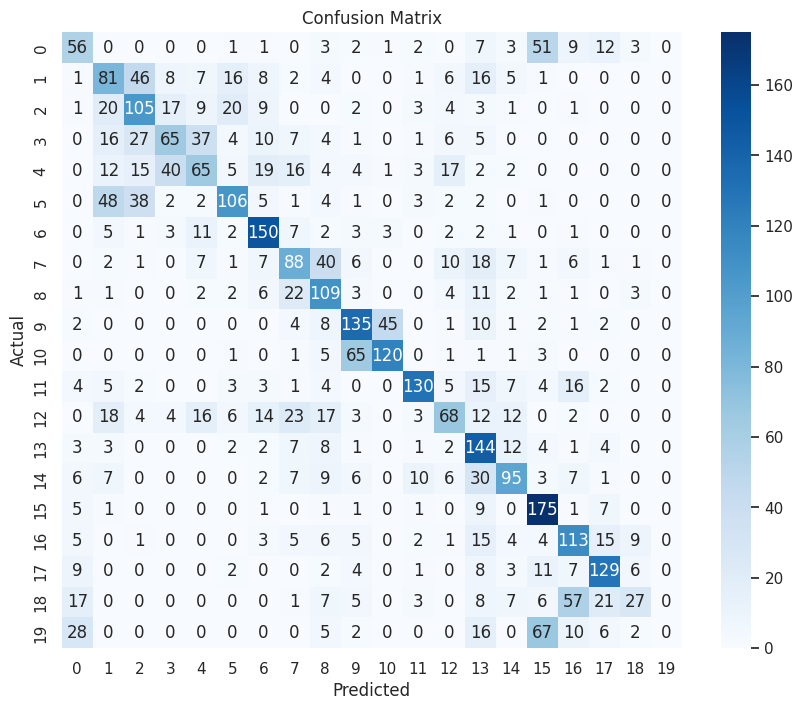

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()